# Comparing time series predictions of COVID-19 deaths

In [1]:
pip install pmdarima

In [2]:
import pmdarima as pm
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import TimeSeriesSplit
import pandas as pd
import numpy as np
import datetime
import requests
import warnings

import matplotlib.pyplot as plt
import matplotlib
import matplotlib.dates as mdates

from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import OrdinalEncoder
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_model import ARIMA
from sklearn.preprocessing import StandardScaler
from fbprophet import Prophet
from fbprophet.plot import plot_plotly, add_changepoints_to_plot
from keras.models import Sequential
from keras.layers import Dense

from keras.optimizers import Adam

warnings.filterwarnings('ignore')


#Open the data and prepare the dataset data frame

In [3]:
deaths_df = pd.read_csv('time_series_covid19_deaths_global.csv')
deaths_df.head()

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,2/20/20,2/21/20,2/22/20,2/23/20,2/24/20,2/25/20,2/26/20,...,7/8/20,7/9/20,7/10/20,7/11/20,7/12/20,7/13/20,7/14/20,7/15/20,7/16/20,7/17/20,7/18/20,7/19/20,7/20/20,7/21/20,7/22/20,7/23/20,7/24/20,7/25/20,7/26/20,7/27/20,7/28/20,7/29/20,7/30/20,7/31/20,8/1/20,8/2/20,8/3/20,8/4/20,8/5/20,8/6/20,8/7/20,8/8/20,8/9/20,8/10/20,8/11/20,8/12/20,8/13/20,8/14/20,8/15/20,8/16/20
0,NaN,Afghanistan,33.93911,67.709953,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,936,957,971,994,1010,1012,1048,1094,1113,1147,1164,1181,1185,1186,1190,1211,1225,1248,1259,1269,1270,1271,1271,1272,1283,1284,1288,1288,1294,1298,1307,1312,1312,1328,1344,1354,1363,1363,1370,1375
1,NaN,Albania,41.15330,20.168300,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,83,83,85,89,93,95,97,101,104,107,111,112,113,117,120,123,128,134,138,144,148,150,154,157,161,166,172,176,182,188,189,193,199,200,205,208,213,219,225,228
2,NaN,Algeria,28.03390,1.659600,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,978,988,996,1004,1011,1018,1028,1040,1052,1057,1068,1078,1087,1100,1111,1124,1136,1146,1155,1163,1174,1186,1200,1210,1223,1231,1239,1248,1261,1273,1282,1293,1302,1312,1322,1333,1341,1351,1360,1370
3,NaN,Andorra,42.50630,1.521800,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,52,52,52,52,52,52,52,52,52,52,52,52,52,52,52,52,52,52,52,52,52,52,52,52,52,52,52,52,52,52,52,52,52,52,52,53,53,53,53,53
4,NaN,Angola,-11.20270,17.873900,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,21,22,23,23,26,26,26,27,28,29,29,29,29,30,33,33,35,39,40,41,47,48,51,52,54,55,58,59,62,64,67,70,75,78,80,80,80,86,86,88


In [4]:
d=deaths_df.loc[:,'1/22/20':]
d.head()

,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,2/20/20,2/21/20,2/22/20,2/23/20,2/24/20,2/25/20,2/26/20,2/27/20,2/28/20,2/29/20,3/1/20,...,7/8/20,7/9/20,7/10/20,7/11/20,7/12/20,7/13/20,7/14/20,7/15/20,7/16/20,7/17/20,7/18/20,7/19/20,7/20/20,7/21/20,7/22/20,7/23/20,7/24/20,7/25/20,7/26/20,7/27/20,7/28/20,7/29/20,7/30/20,7/31/20,8/1/20,8/2/20,8/3/20,8/4/20,8/5/20,8/6/20,8/7/20,8/8/20,8/9/20,8/10/20,8/11/20,8/12/20,8/13/20,8/14/20,8/15/20,8/16/20
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,936,957,971,994,1010,1012,1048,1094,1113,1147,1164,1181,1185,1186,1190,1211,1225,1248,1259,1269,1270,1271,1271,1272,1283,1284,1288,1288,1294,1298,1307,1312,1312,1328,1344,1354,1363,1363,1370,1375
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,83,83,85,89,93,95,97,101,104,107,111,112,113,117,120,123,128,134,138,144,148,150,154,157,161,166,172,176,182,188,189,193,199,200,205,208,213,219,225,228
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,978,988,996,1004,1011,1018,1028,1040,1052,1057,1068,1078,1087,1100,1111,1124,1136,1146,1155,1163,1174,1186,1200,1210,1223,1231,1239,1248,1261,1273,1282,1293,1302,1312,1322,1333,1341,1351,1360,1370
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,52,52,52,52,52,52,52,52,52,52,52,52,52,52,52,52,52,52,52,52,52,52,52,52,52,52,52,52,52,52,52,52,52,52,52,53,53,53,53,53
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,21,22,23,23,26,26,26,27,28,29,29,29,29,30,33,33,35,39,40,41,47,48,51,52,54,55,58,59,62,64,67,70,75,78,80,80,80,86,86,88


In [5]:
d=d.transpose()

In [6]:
d=d.sum(axis=1)

In [7]:
d=d.to_list()

In [8]:
dataset=pd.DataFrame(columns=['ds','y'])

In [9]:
dates=list(deaths_df.columns[4:])

In [10]:
dates=list(pd.to_datetime(dates))

In [11]:
dataset['ds']=dates
dataset['y']=d

In [12]:
dataset=dataset.set_index('ds')

Let's plot the daily number of deaths


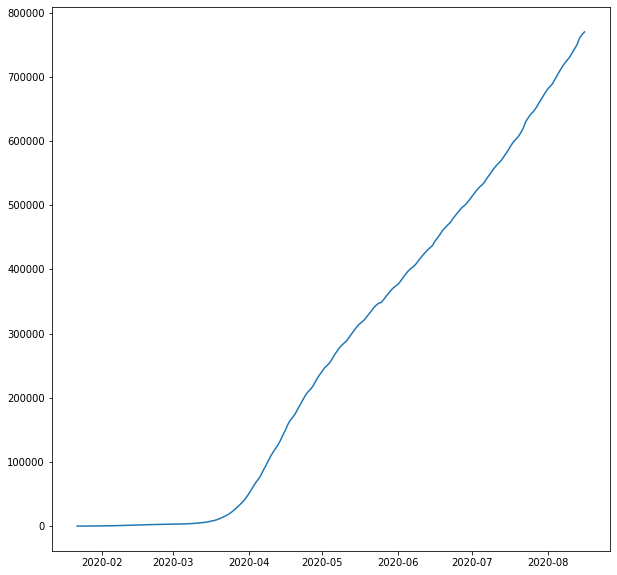

In [13]:
plt.figure(figsize=(10,10))
plt.plot(dataset)
plt.savefig('Cumulative daily deaths',bbox_inches='tight',transparent=False)

and let's see how the daily increase looks like. To do this, we will use the `diff` method from the Dataframe object.

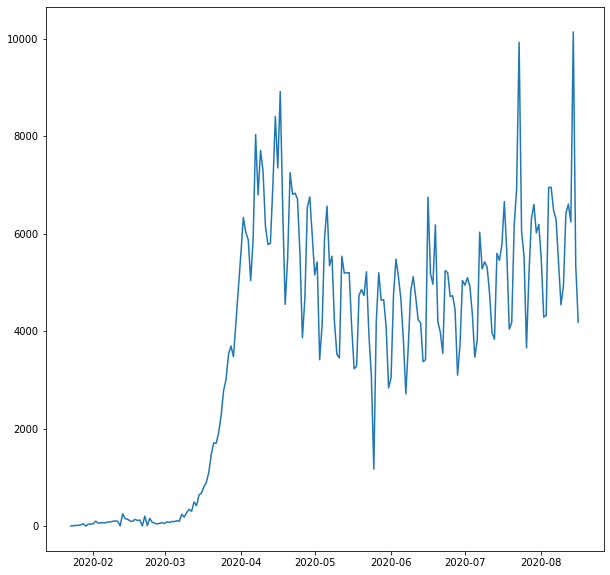

In [14]:
plt.figure(figsize=(10,10))
plt.plot(dataset.diff())
plt.savefig('Daily deaths',bbox_inches='tight',transparent=False)

In [15]:
dataset=dataset.diff()

In [16]:
dataset=dataset.loc['2020-01-23':'2020-08-13']

#Forcasting using SARIMAX, or Seasonal AutoRegressive Integrated Moving Average with eXogenous regressors model

In [17]:
start_date='2020-07-31'
train=dataset.loc[dataset.index<pd.to_datetime(start_date)]
test=dataset.loc[dataset.index>=pd.to_datetime(start_date)]

In [18]:
model=SARIMAX(train,order=(2,1,3))

In [19]:
results=model.fit(disp=True)

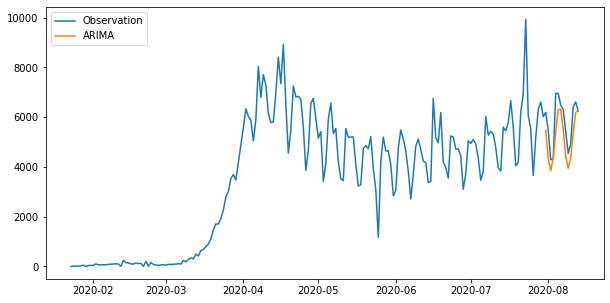

In [20]:
sarimax_prediction=results.predict(start=start_date,end='2020-08-13',dynamic=False)
plt.figure(figsize=(10,5))
l1,=plt.plot(dataset,label='Observation')
l2,=plt.plot(sarimax_prediction,label='ARIMA')
plt.legend(handles=[l1, l2])
plt.savefig('SARIMAX Prediction',bbox_inches='tight',transparent=False)

In [21]:
print('SARIMAX MAE = ',mean_absolute_error(sarimax_prediction,test))

SARIMAX MAE =  650.6154682219609


In [22]:
model = pm.auto_arima(train, start_p=1, start_q=1,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3,  # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0,
                      D=0,
                      trace=True,
                      error_action='ignore',
                      suppress_warnings=True,
                      stepwise=True)

print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3111.971, Time=0.27 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=3132.320, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=3133.730, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3133.267, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=3130.535, Time=0.01 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=3099.414, Time=0.47 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=3128.118, Time=0.05 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=3089.597, Time=0.50 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=3116.490, Time=0.06 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=3043.847, Time=0.67 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3040.433, Time=0.55 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3106.308, Time=0.46 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=3025.720, Time=0.77 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=3105.847, Time=0.50 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept

Note that this gives us the best mode here: "Best model:  SARIMAX(2,2,3)(0,0,0)[0]"

#Forcasting using Facebook's Prophet model

In [23]:
train['ds']=train.index.values

In [24]:
m=Prophet()
m.fit(train)

INFO:numexpr.utils:NumExpr defaulting to 2 threads.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [25]:
future=m.make_future_dataframe(periods=dataset.shape[0]-train.shape[0])
prophet_prediction=m.predict(future)

In [26]:
prophet_prediction=prophet_prediction.set_index('ds')
prophet_future=prophet_prediction.yhat.loc[prophet_prediction.index>=start_date]
print('Facebook Prophet MAE = ',mean_absolute_error(prophet_future,test))


Facebook Prophet MAE =  571.8872860781038


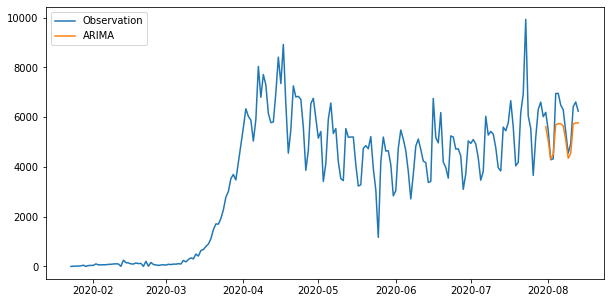

In [27]:
plt.figure(figsize=(10,5))
l1,=plt.plot(dataset,label='Observation')
l2,=plt.plot(prophet_future,label='ARIMA')
plt.legend(handles=[l1, l2])
plt.savefig('Facebook Prophet Prediction',bbox_inches='tight',transparent=False)

#Preparing the dataset for XGBOOST and NN

In [28]:
def featurize(t):
  X=pd.DataFrame()
  X['day']=t.index.day
  X['month']=t.index.month
  X['quarter']=t.index.quarter
  X['dayofweek']=t.index.dayofweek
  X['dayofyear']=t.index.dayofyear
  X['weekofyear']=t.index.weekofyear
  y=t.y
  return X,y
featurize(dataset)[0].head()

,day,month,quarter,dayofweek,dayofyear,weekofyear
0,23,1,1,3,23,4
1,24,1,1,4,24,4
2,25,1,1,5,25,4
3,26,1,1,6,26,4
4,27,1,1,0,27,5


#Create training and test datasets by splitting the dataset, and perform data normalization.

In [29]:
X_train,y_train=featurize(dataset.loc[dataset.index<pd.to_datetime(start_date)])
X_test,y_test=featurize(dataset.loc[dataset.index>=pd.to_datetime(start_date)])

In [30]:
scaler=StandardScaler()
scaler.fit(X_train)

StandardScaler(copy=True, with_mean=True, with_std=True)

In [31]:
scaled_train=scaler.transform(X_train)
scaled_test=scaler.transform(X_test)

#Train the XGBOOST and NN models

In [32]:
XGBOOST_model=XGBRegressor(n_estimators=50)

In [33]:
XGBOOST_model.fit(scaled_train,y_train,eval_set=[(scaled_train,y_train),(scaled_test,y_test)],verbose=True)
XGBOOST_prediction=XGBOOST_model.predict(scaled_test)

[13:23:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:3926.27	validation_1-rmse:5364.15
[1]	validation_0-rmse:3563.2	validation_1-rmse:4909.52
[2]	validation_0-rmse:3234.76	validation_1-rmse:4536.32
[3]	validation_0-rmse:2939.88	validation_1-rmse:4200.33
[4]	validation_0-rmse:2674.4	validation_1-rmse:3862.47
[5]	validation_0-rmse:2439.07	validation_1-rmse:3591.74
[6]	validation_0-rmse:2223.52	validation_1-rmse:3261.25
[7]	validation_0-rmse:2030.4	validation_1-rmse:2963.19
[8]	validation_0-rmse:1855.85	validation_1-rmse:2740.28
[9]	validation_0-rmse:1700.05	validation_1-rmse:2505.91
[10]	validation_0-rmse:1559.18	validation_1-rmse:2295.18
[11]	validation_0-rmse:1434.67	validation_1-rmse:2149.84
[12]	validation_0-rmse:1322.91	validation_1-rmse:2003.42
[13]	validation_0-rmse:1221.68	validation_1-rmse:1821.29
[14]	validation_0-rmse:1132.53	validation_1-rmse:1640.87
[15]	validation_0-rmse:1051.37	

In [34]:
print('XGBOOST MAE = ',mean_absolute_error(XGBOOST_prediction,test))

XGBOOST MAE =  428.85062081473217


In [35]:
NN_model=Sequential()
NN_model.add(Dense(20,input_shape=(scaled_train.shape[1],)))
NN_model.add(Dense(10))
NN_model.add(Dense(1))
NN_model.compile(loss='mean_absolute_error',optimizer=Adam(lr=0.001))
NN_model.fit(scaled_train,y_train,validation_data=(scaled_test,y_test),epochs=220,verbose=1)
NN_prediction=NN_model.predict(scaled_test)

Epoch 1/220
6/6 [==============================] - 14s 95ms/step - loss: 3688.1213 - val_loss: 5794.0537
Epoch 2/220
6/6 [==============================] - 0s 5ms/step - loss: 3514.8777 - val_loss: 5794.0264
Epoch 3/220
6/6 [==============================] - 0s 5ms/step - loss: 3516.4815 - val_loss: 5793.9141
Epoch 4/220
6/6 [==============================] - 0s 5ms/step - loss: 3395.6722 - val_loss: 5793.8706
Epoch 5/220
6/6 [==============================] - 0s 5ms/step - loss: 3608.3119 - val_loss: 5793.8228
Epoch 6/220
6/6 [==============================] - 0s 5ms/step - loss: 3779.6844 - val_loss: 5793.7065
Epoch 7/220
6/6 [==============================] - 0s 5ms/step - loss: 3442.5677 - val_loss: 5793.6362
Epoch 8/220
6/6 [==============================] - 0s 5ms/step - loss: 3543.2148 - val_loss: 5793.5381
Epoch 9/220
6/6 [==============================] - 0s 6ms/step - loss: 3380.1508 - val_loss: 5793.4878
Epoch 10/220
6/6 [==============================] - 0s 5ms/step - loss:

In [36]:
print('XGBOOST MAE = ',mean_absolute_error(XGBOOST_prediction,test))
print('Facebook Prophet MAE = ',mean_absolute_error(prophet_future,test))
print('Facebook Prophet MAE = ',mean_absolute_error(sarimax_prediction,test))
print('NN model MAE = ',mean_absolute_error(NN_prediction,test))


XGBOOST MAE =  428.85062081473217
Facebook Prophet MAE =  571.8872860781038
Facebook Prophet MAE =  650.6154682219609
NN model MAE =  728.2560686383929


<Figure size 1440x1440 with 0 Axes>

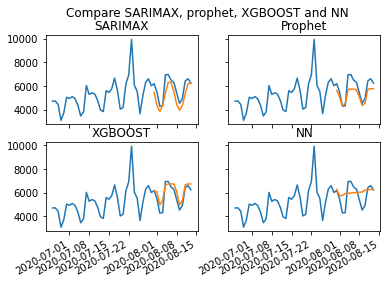

In [37]:

XGBOOST_df = pd.DataFrame({'y': XGBOOST_prediction.tolist()})
XGBOOST_df.index = y_test.index

NN_df = pd.DataFrame(NN_prediction)
NN_df.index = y_test.index
plt.figure(figsize=(20, 20))
fig, axs = plt.subplots(2, 2)
fig.suptitle('Compare SARIMAX, prophet, XGBOOST and NN')
axs[0, 0].plot(dataset.tail(50))
axs[0, 0].plot(sarimax_prediction.tail(50))
axs[0, 0].set_title("SARIMAX")
axs[0, 1].plot(dataset.tail(50))
axs[0, 1].plot(prophet_future.tail(50))
axs[0, 1].set_title("Prophet")
axs[1, 0].plot(dataset.tail(50))
axs[1, 0].plot(XGBOOST_df.tail(50))
axs[1, 0].set_title("XGBOOST")
axs[1, 1].plot(dataset.tail(50))
axs[1, 1].plot(NN_df.tail(50))
axs[1, 1].set_title("NN")

for ax in fig.get_axes():
    ax.label_outer()
fig.autofmt_xdate()

plt.savefig('Comparison',
            bbox_inches='tight', transparent=False)